In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from glob import glob
import os

from sklearn.preprocessing import StandardScaler

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm
from sklearn import metrics
from sklearn import model_selection as ms
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

#from rerf.rerfClassifier import rerfClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score

import warnings
warnings.simplefilter('ignore')

In [2]:
def prepare_data_train(fname_d,fname_e):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname_d)
    # events file
    #events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(fname_e)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels


def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data

scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_preprocess_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep

In [5]:
subsample=100 # training subsample.if you want to downsample the training data
#######columns name for labels#############
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

#######number of subjects###############
subjects = range(1,10)
ids_tot = []
pred_tot = []
X = []
Y = []
###loop on subjects and 8 series for train data + 2 series for test data
for subject in subjects:
    y_raw= []
    raw = []
    ################ READ DATA ################################################
    for i in range(1,2):
        fname_d =  'D:/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_data.csv' % (i)
        fname_e =  'D:/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_events.csv' % (i)
        data,labels=prepare_data_train(fname_d,fname_e)
        raw.append(data)
        y_raw.append(labels)
        

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #print (length(X))
    #print (length(y))
    #transform in numpy array
    #transform train data in numpy array
    X_train =np.asarray(X.astype(float))
    Y_train = np.asarray(y.astype(float))

In [6]:
segment_len = 12
slide_len = 4
shuff_seg = []
shuff_y = []
segments = X_train
seg_y = Y_train
for start_pos in range(0, len(segments), slide_len):
    end_pos = start_pos + segment_len
    # make a copy of segment
    seg = segments[start_pos:end_pos,:]
    segment = np.mean(seg,axis = 0)
    y_seg = np.max(seg_y[start_pos:end_pos],axis = 0)
    # if we're at the end and we've got a truncated segment, drop it
    if len(seg) != segment_len:
        break
    shuff_seg.append(segment)
    shuff_y.append(y_seg)

shuff_seg = np.asarray(shuff_seg)
shuff_y = np.asarray(shuff_y)

print(shuff_seg.shape,shuff_y.shape)
#selecting channel
X_train_seg = shuff_seg
#Y-values for grasp
Y_train_seg = shuff_y[:,1]
print(X_train_seg.shape, Y_train_seg.shape)

(35354, 32) (35354, 6)
(35354, 32) (35354,)


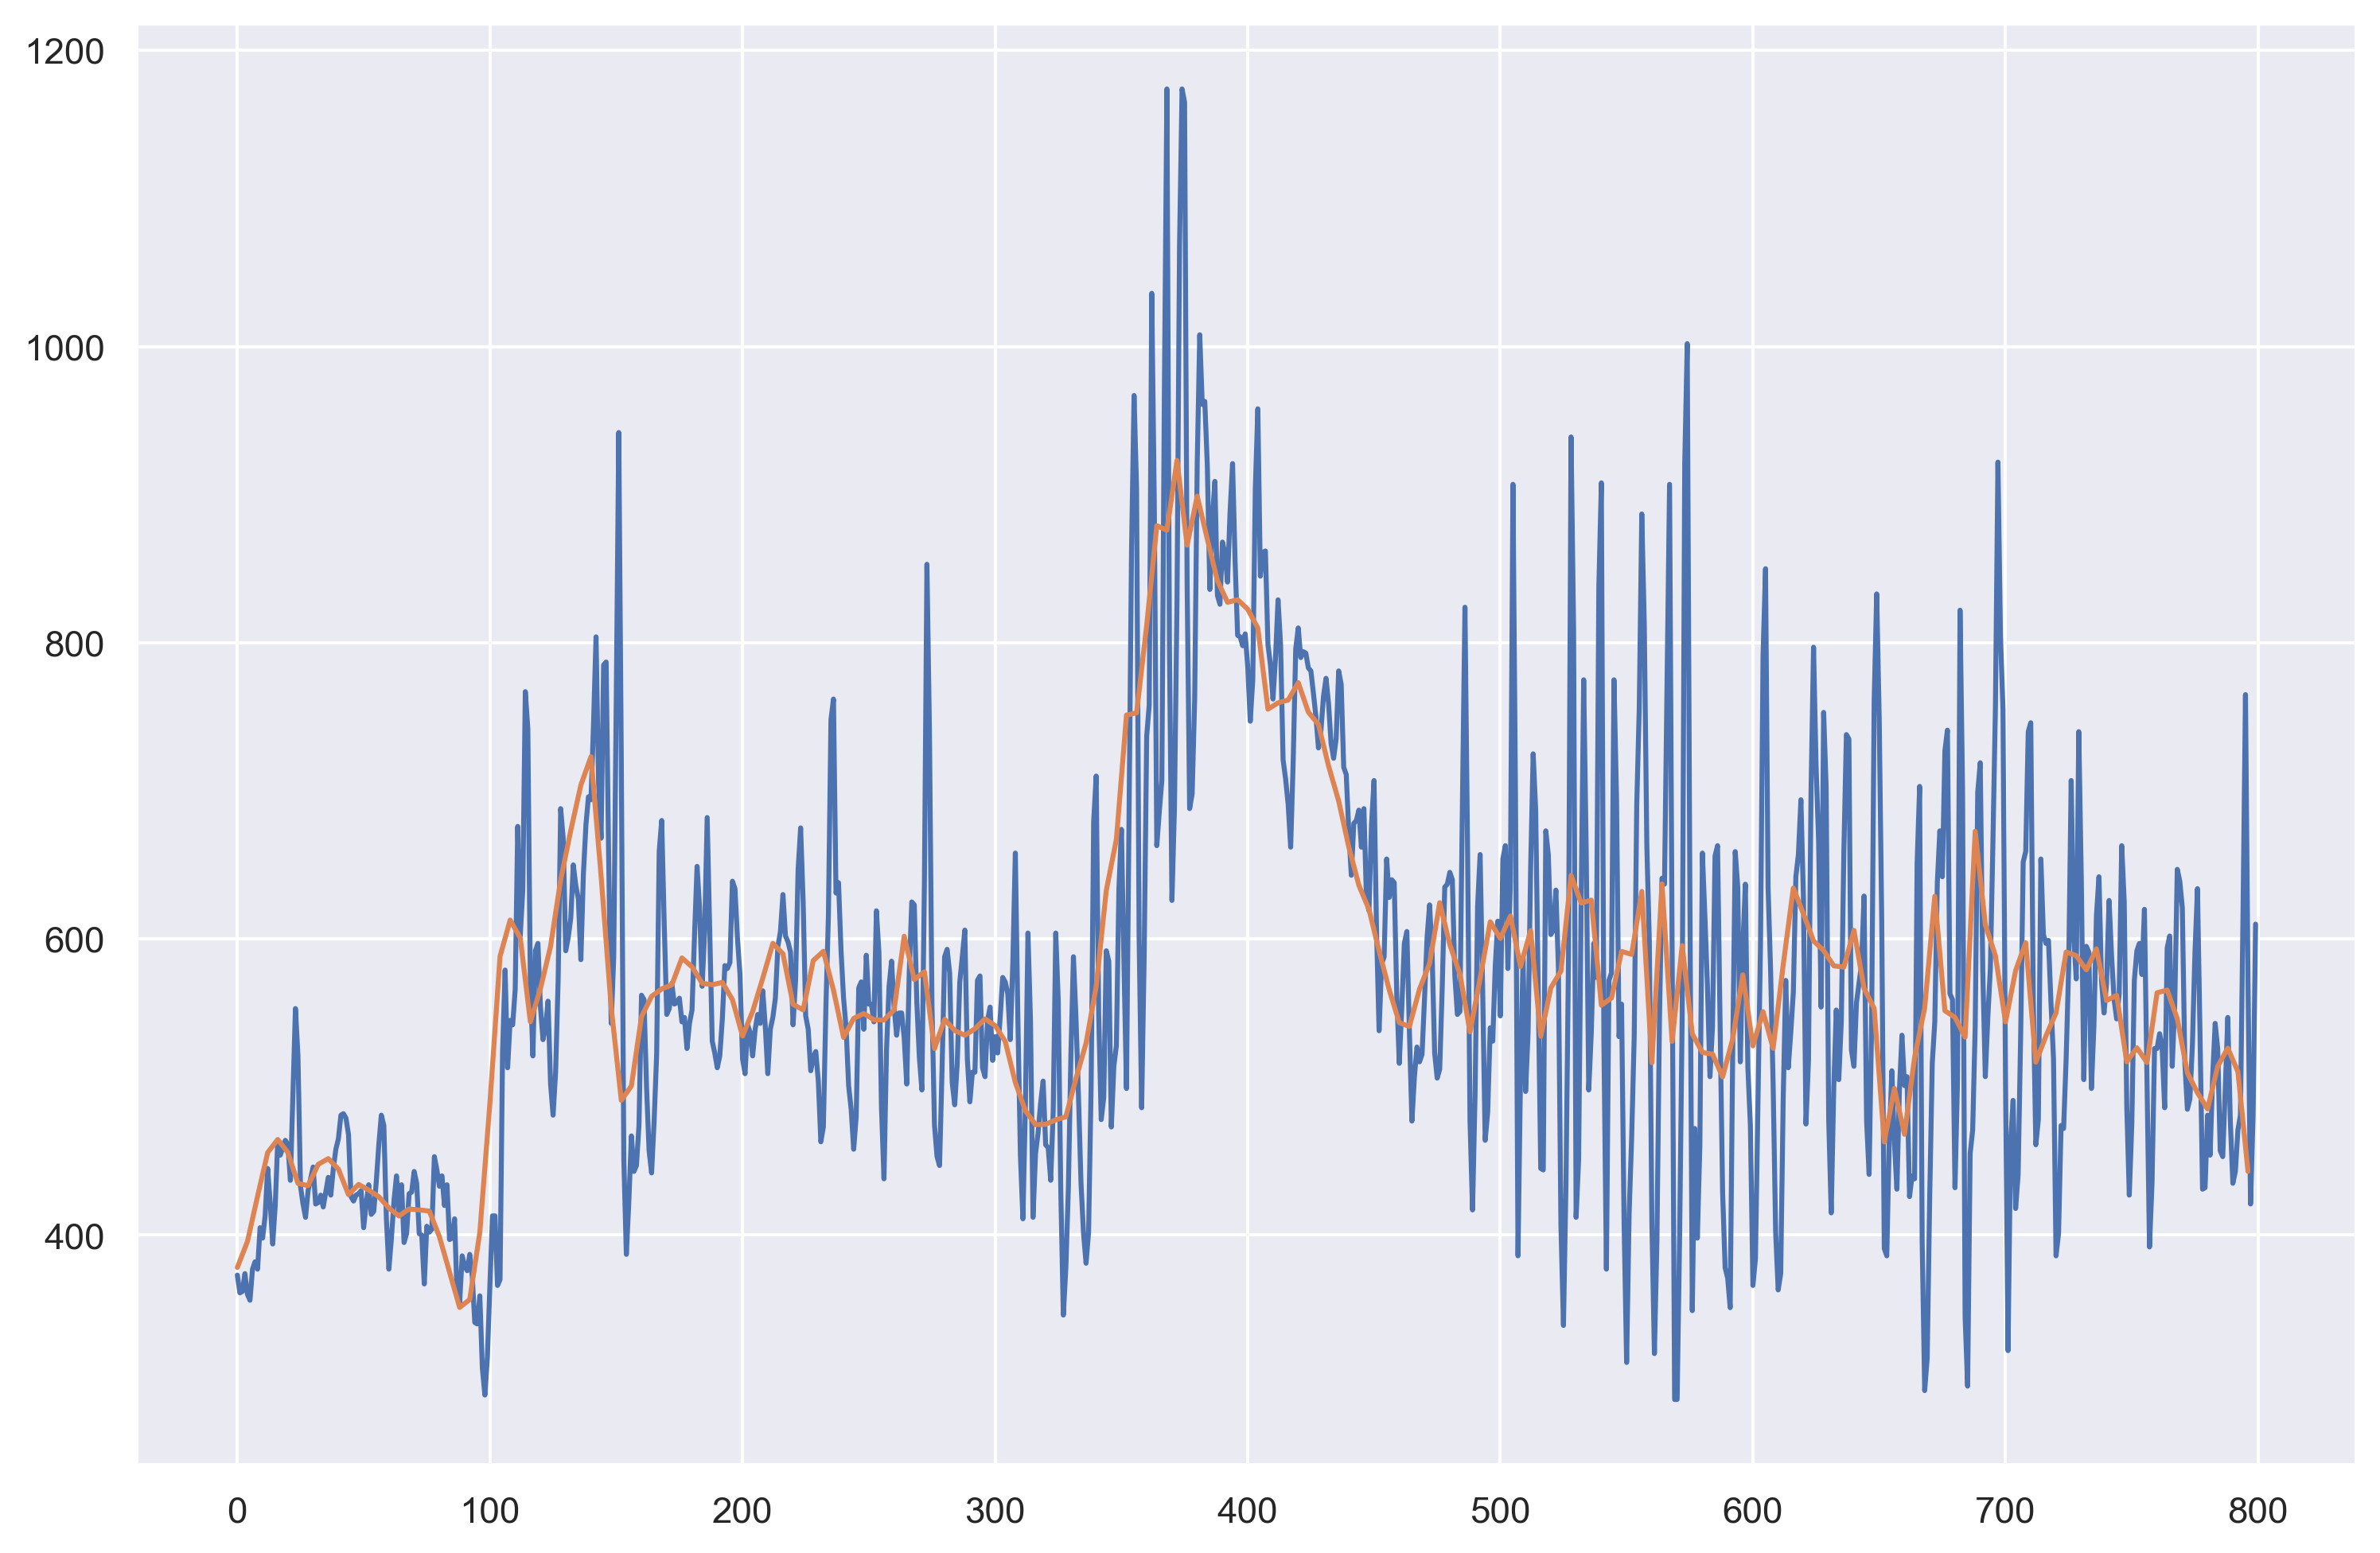

In [10]:
t = X_train[1200:2000,5]
t_seg = X_train_seg[300:500,5]
time = range(0,800)
time2 = range(0,800,slide_len)
plt.plot(time,t)
plt.plot(time2,t_seg)

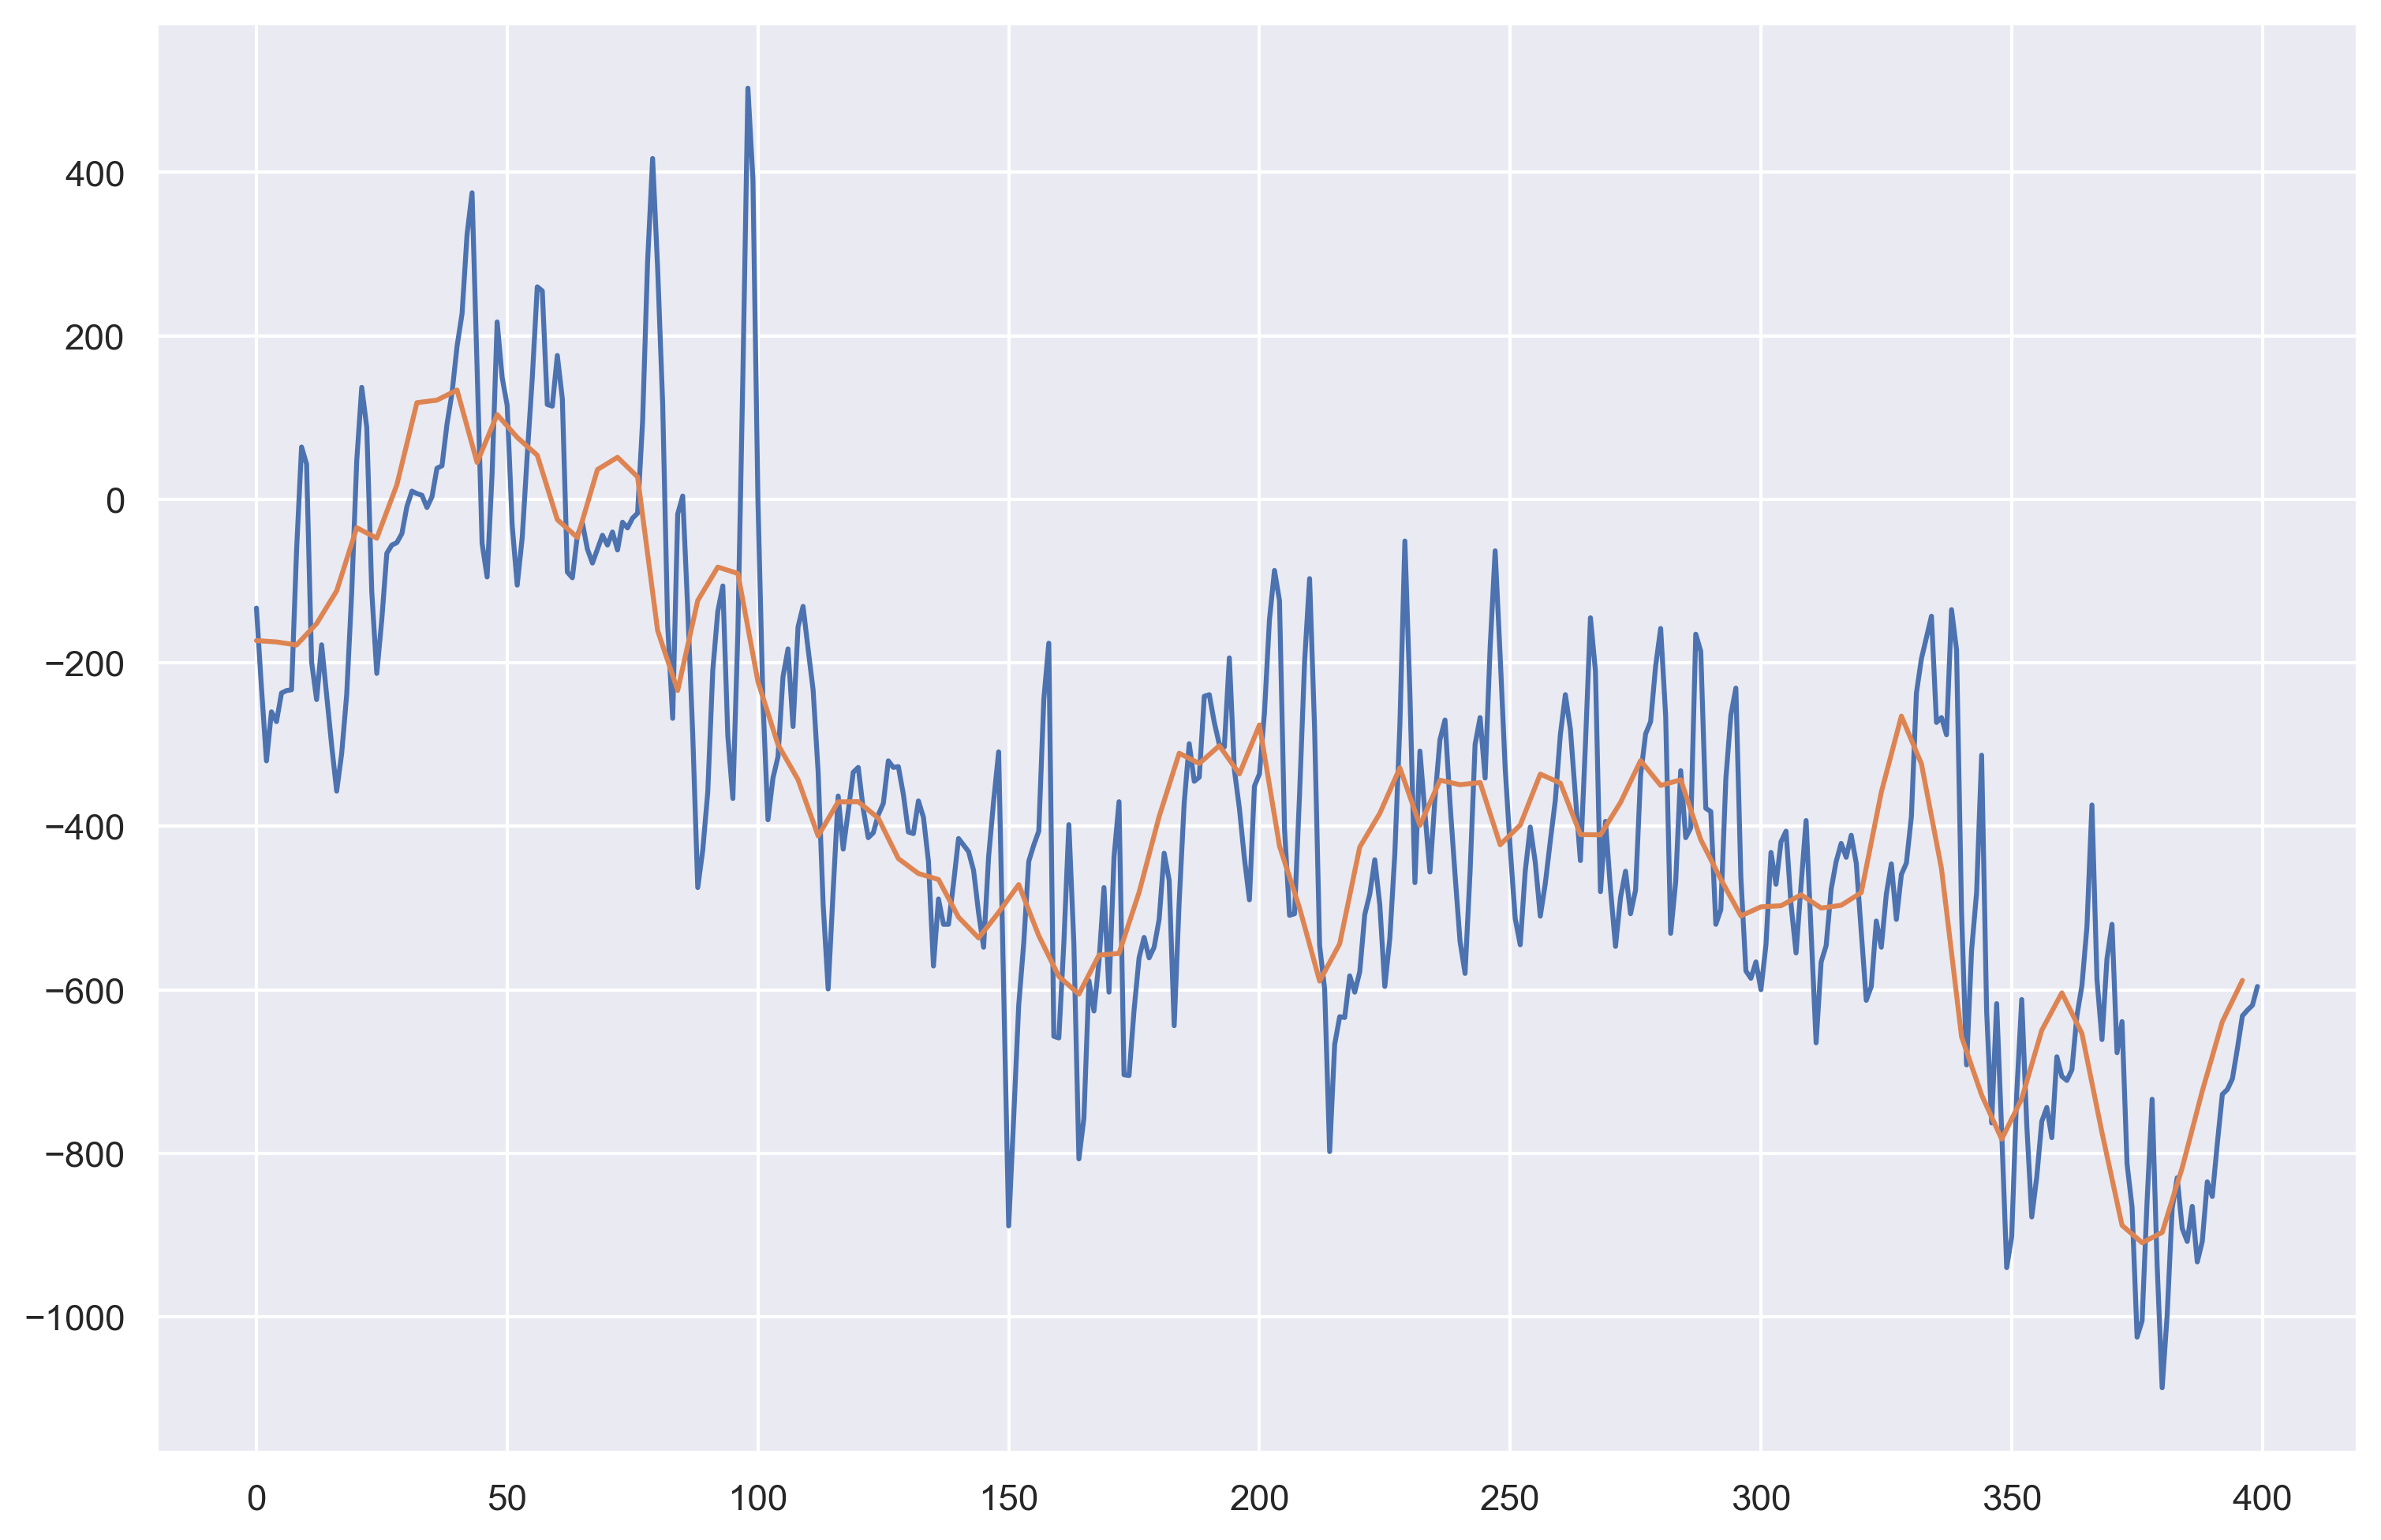

In [20]:
t = X_train[1200:1600,30]
t_seg = X_train_seg[300:400,30]
time = range(0,400)
time2 = range(0,400,slide_len)
plt.plot(time,t)
plt.plot(time2,t_seg)

TypeError: no numeric data to plot

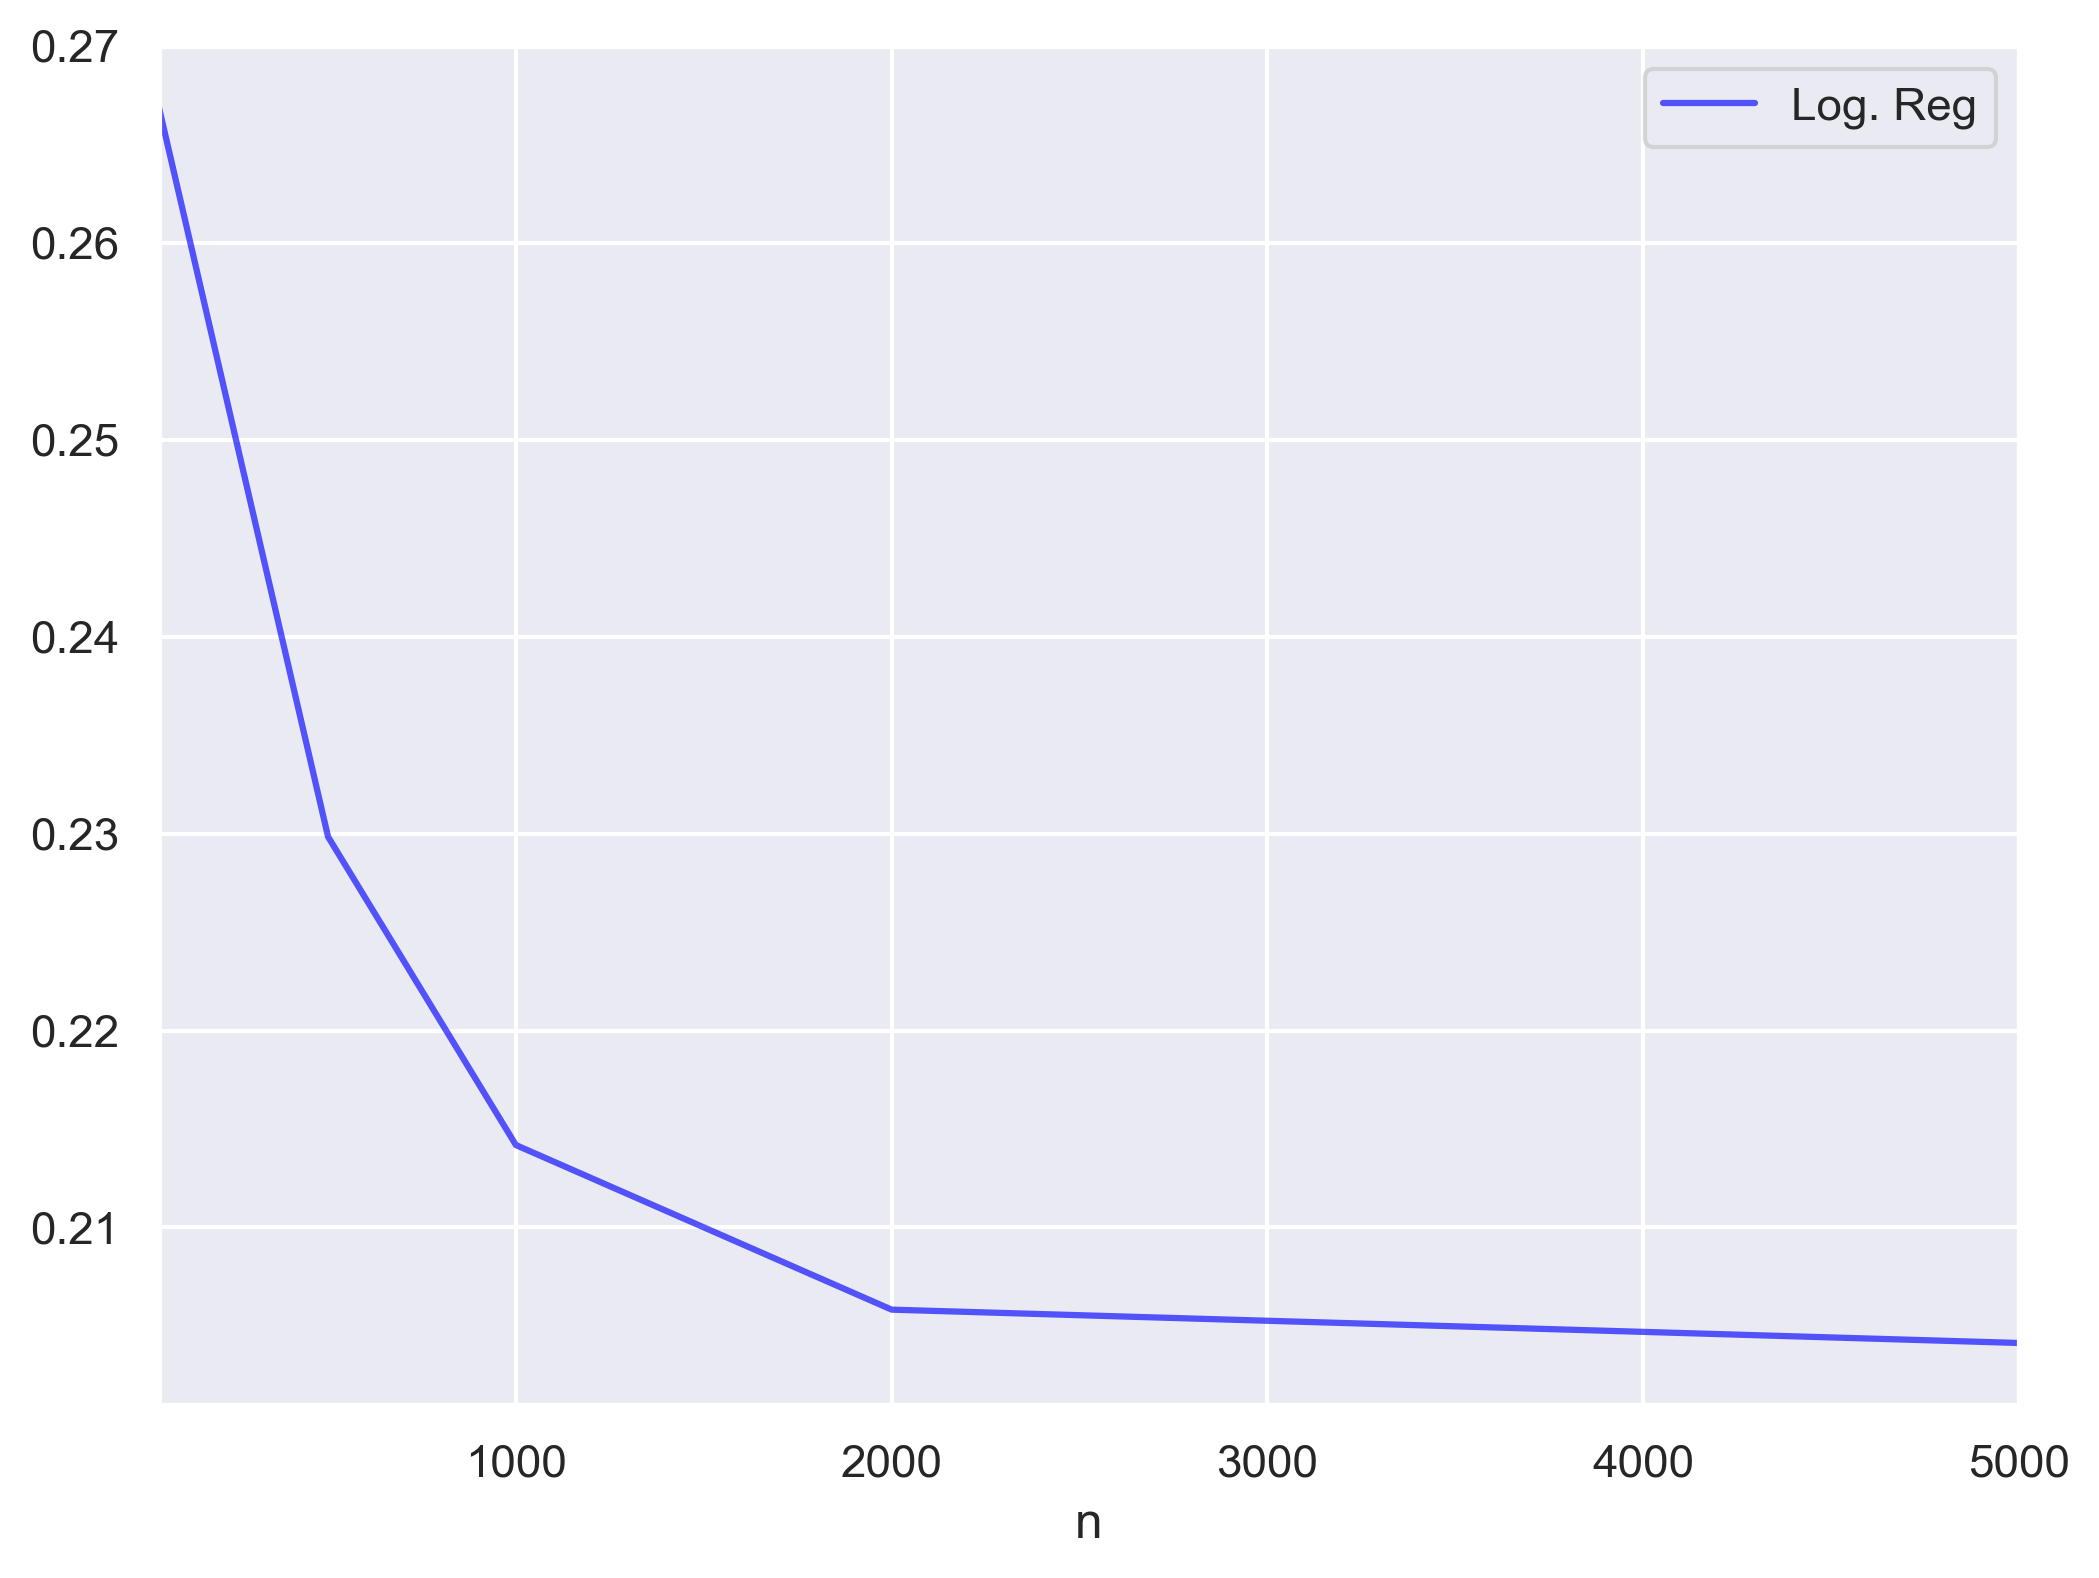

In [8]:
## Read output file log and plot mean test error
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", #"SVM":"purple","kNN": "black", 
        "RF":"#f86000", "MLP":"green", "S-RerF":"red"}
dat = pd.read_csv("D:/UbuntuFiles/eeg_grasp_more iter1.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]
        #print(tmp)
        se = stats.sem(tmp['Lhat'].astype(float))
        #print(tmp['Lhat'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_xscale('log')

plt.legend(loc='upper right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()

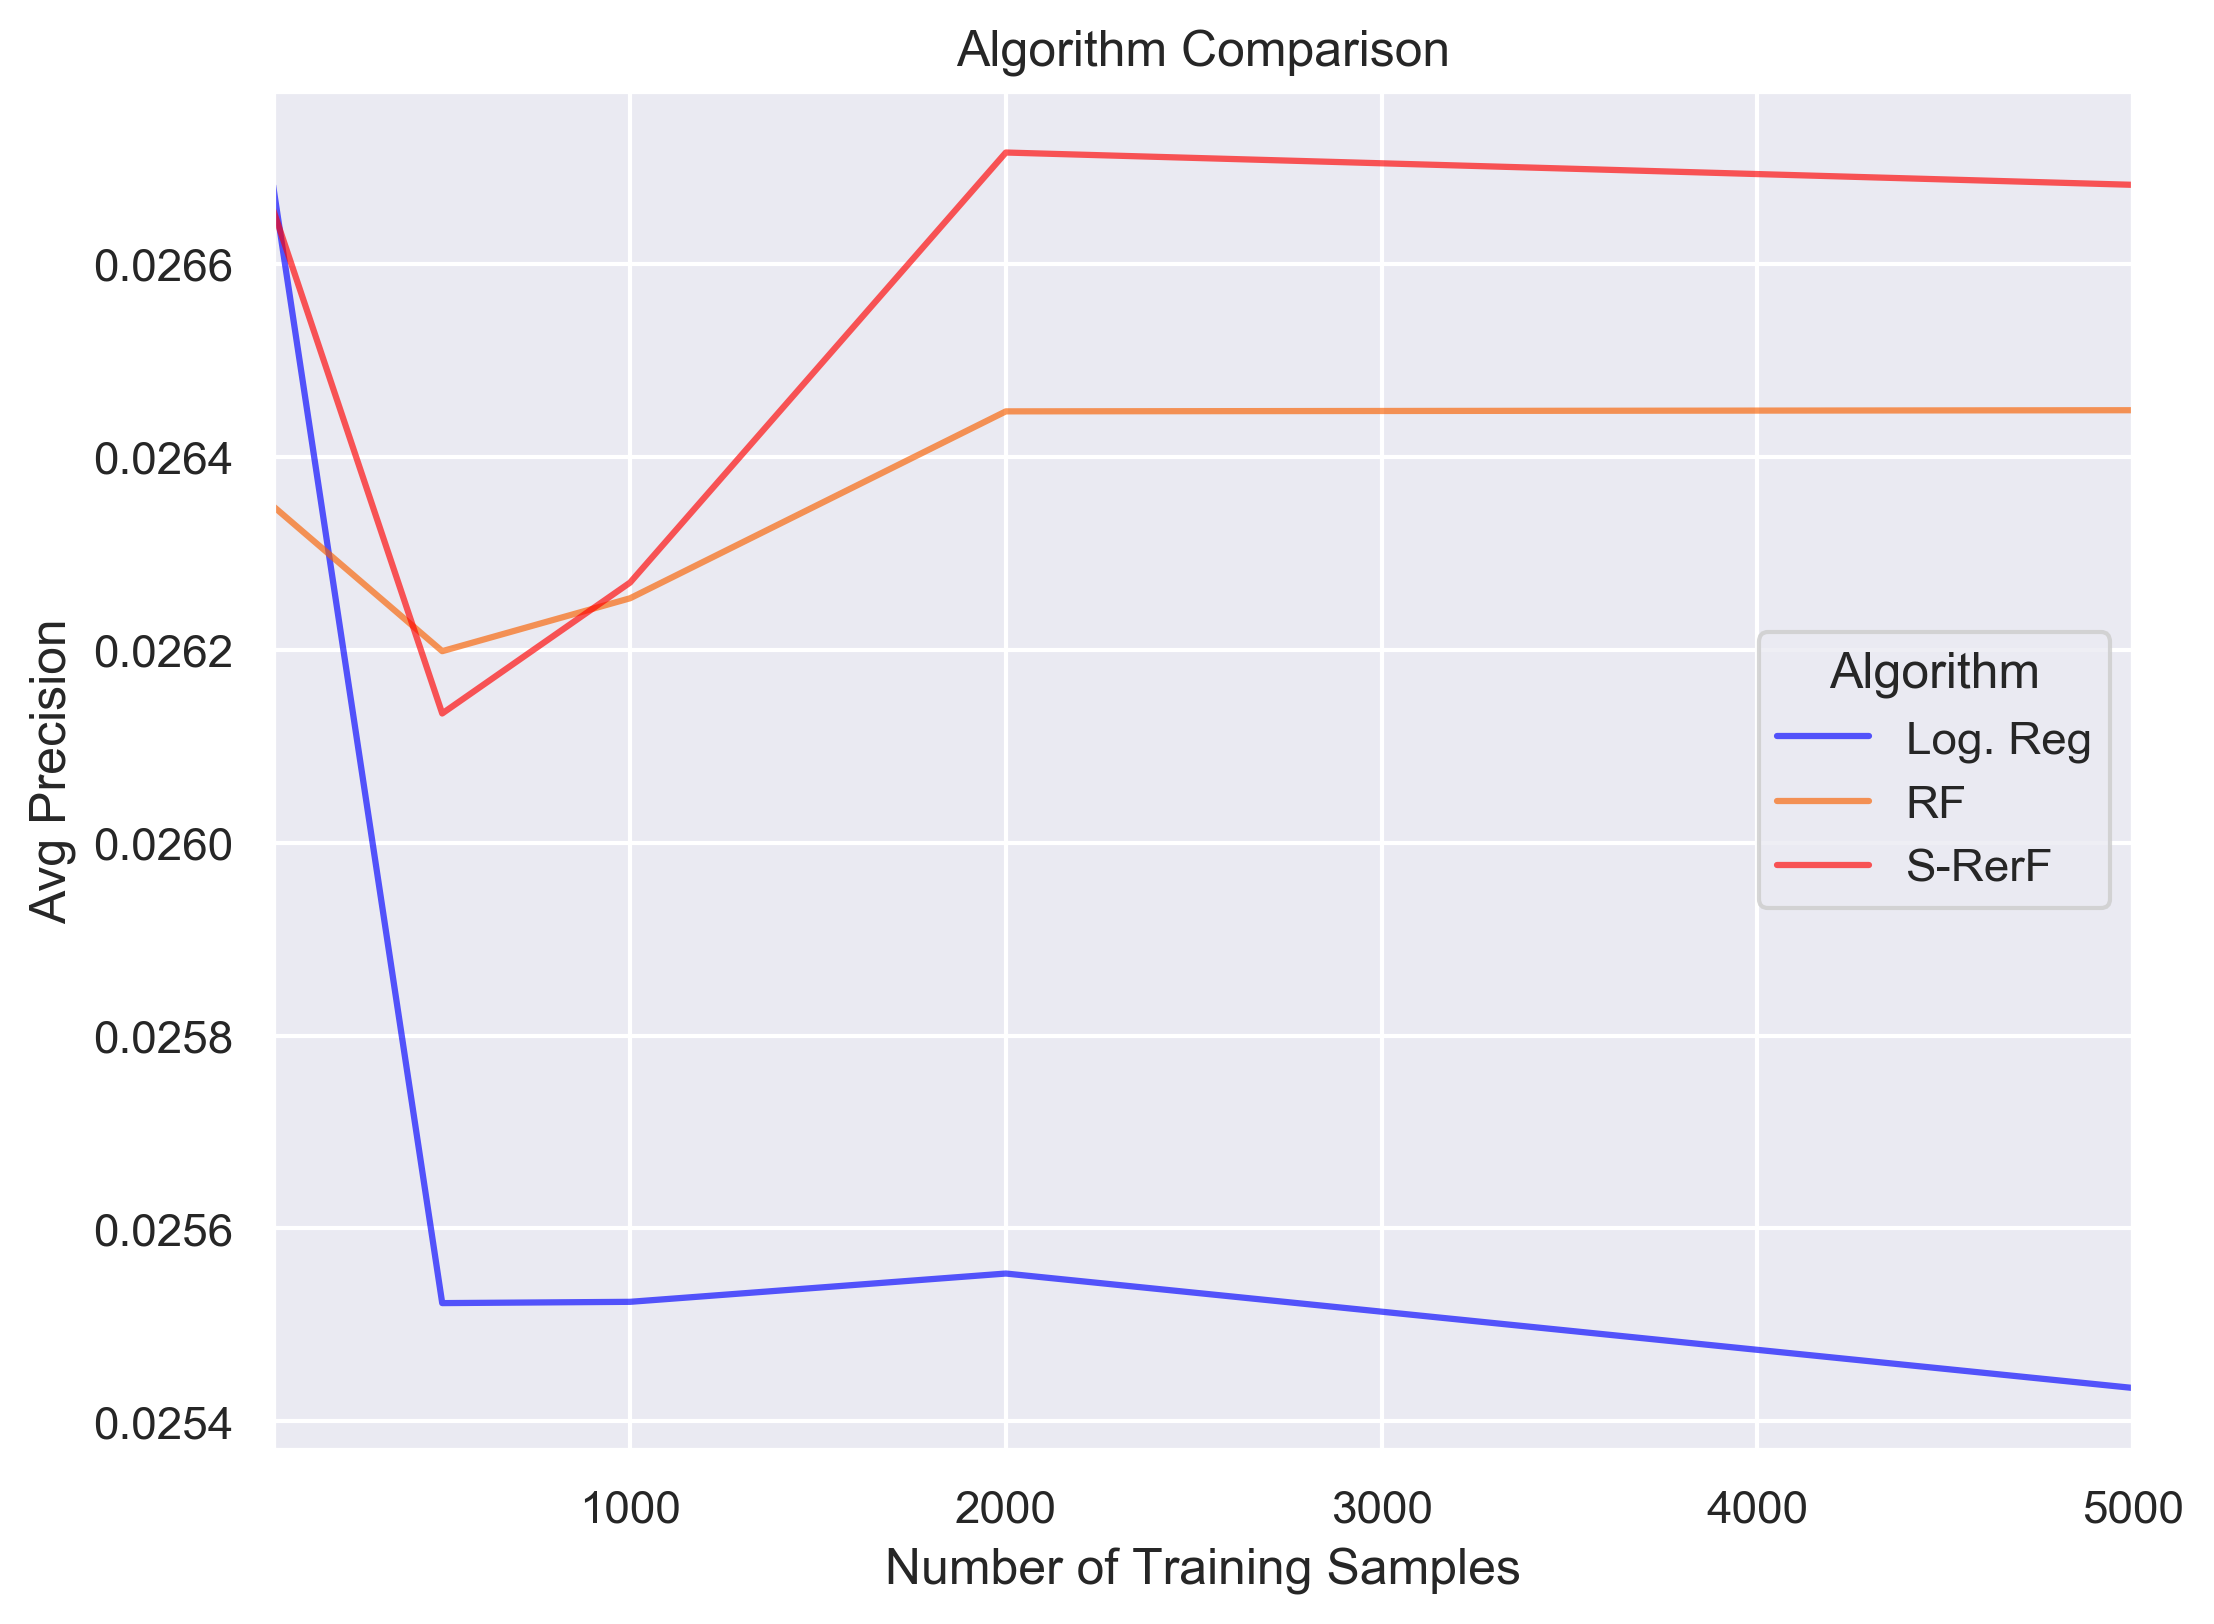

In [6]:
## Read output file log and plot average precision
dat = pd.read_csv("D:/UbuntuFiles/eeg_grasp_more iter1.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Precision', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Precision']]
        #print(tmp)
        se = stats.sem(tmp['Precision'].astype(float))
        #print(tmp['Precision'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Precision', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_xscale('log')

plt.legend(loc='Upper right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Avg Precision')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()

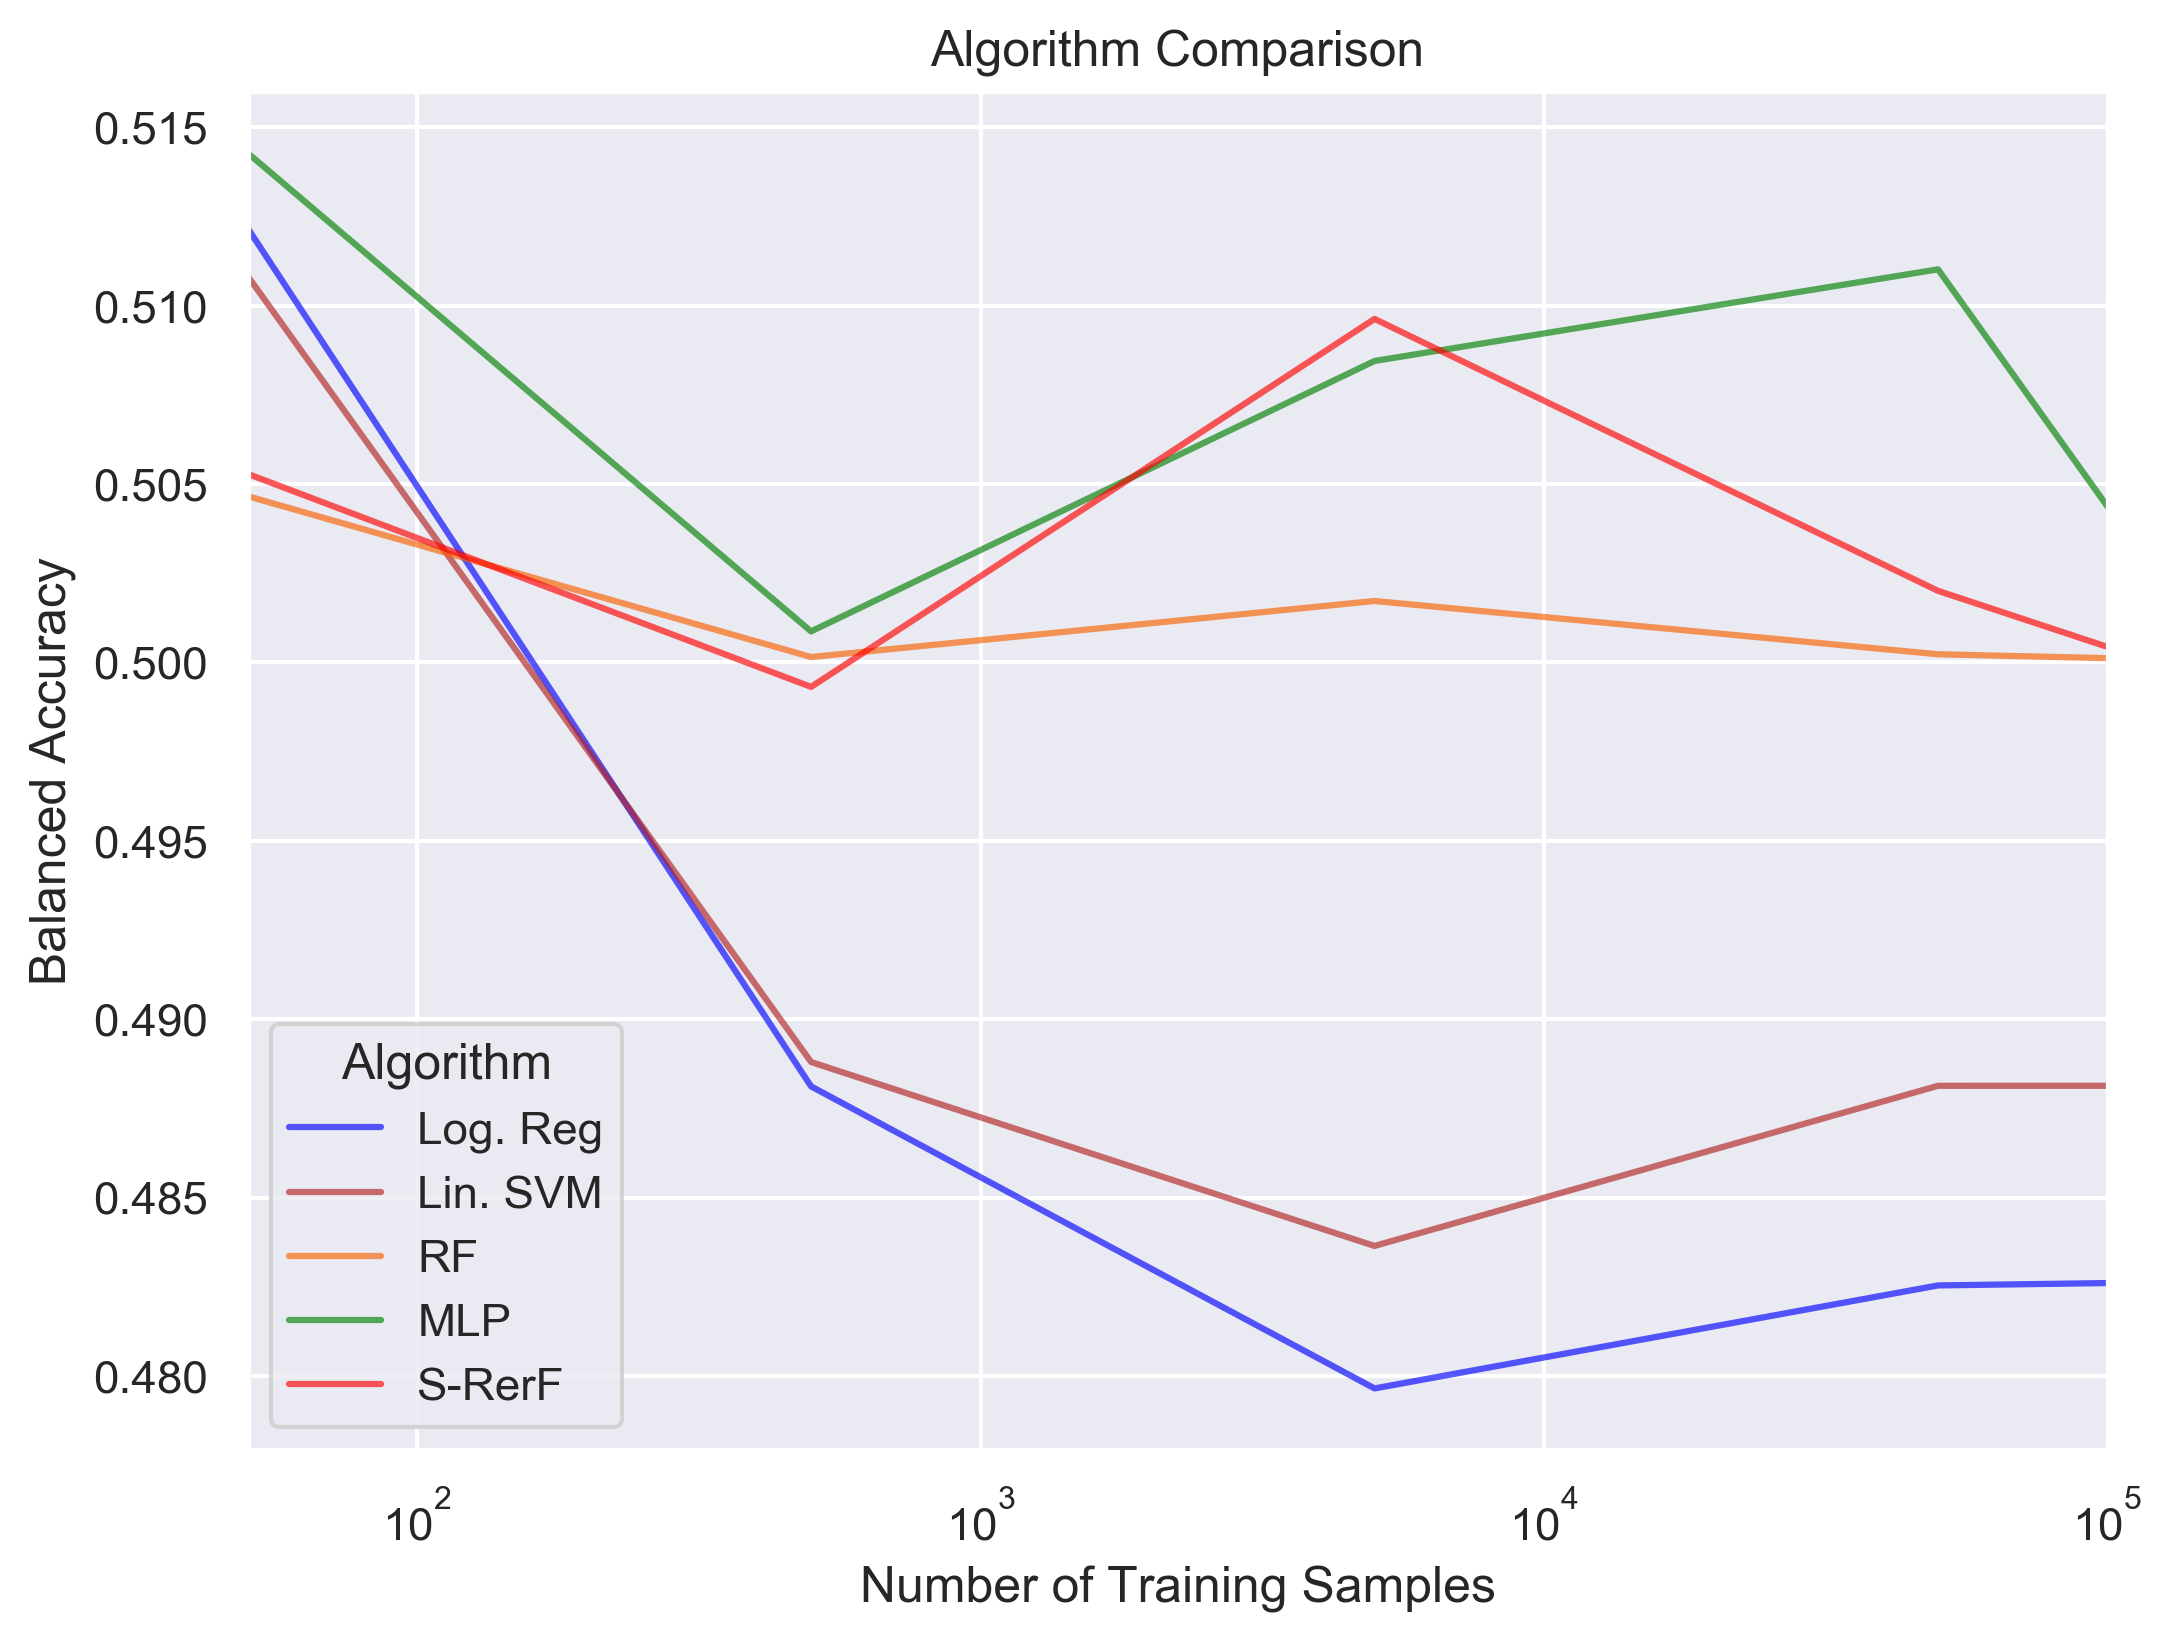

In [13]:
## Read output file log and plot Balanced Accuracy
dat = pd.read_csv("D:/UbuntuFiles/eeg_grasp_pre_lhat_bin3.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'BACC', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'BACC']]
        #print(tmp)
        se = stats.sem(tmp['BACC'].astype(float))
        #print(tmp['Precision'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='BACC', label=key, \
            c = names[key], alpha =0.65)
    ax.set_xscale('log')

plt.legend(loc='Upper right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Balanced Accuracy')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()